# Preprocessing Xarray data array

In [1]:
import baspy as bp
import pandas as pd
from downloader import dataprocessing
from downloader import helper
import numpy as np
import xarray as xr

# Other libraries you may need to install:
# calendar, itertools, pickle, datetime, sklearn, scipy, matplotlib

## Load example xarray dataset from JASMIN using baspy

In [2]:
# Retrieve catalogue from JASMIN
catlg = bp.catalogue(dataset='cmip5', Model='HadGEM2-CC', Frequency='day', Experiment='historical', RunID='r1i1p1', Var='tas').reset_index(drop=True)
catlg

Updating cached catalogue...
catalogue memory usage (MB): 28.786099
>> Current cached values (can be extended by specifying additional values or by setting read_everything=True) <<
{'Experiment': ['rcp45', 'piControl', 'rcp85', 'historical', 'rcp26'], 'Frequency': ['day', 'mon']}



,Centre,Model,Experiment,Frequency,SubModel,CMOR,RunID,Version,Var,StartDate,EndDate,Path,DataFiles,dataset
0,MOHC,HadGEM2-CC,historical,day,atmos,day,r1i1p1,v20110930,tas,18591201,20051130,/MOHC/HadGEM2-CC/historical/day/atmos/day/r1i1...,tas_day_HadGEM2-CC_historical_r1i1p1_18591201-...,cmip5


In [3]:
# Retrieve daily data array
var = catlg.iloc[0].Var
da = bp.open_dataset(catlg.iloc[0])[var]
da

<xarray.DataArray 'tas' (time: 52560, lat: 145, lon: 192)>
dask.array<shape=(52560, 145, 192), dtype=float32, chunksize=(1800, 145, 192)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 1.5
  * time     (time) object 1859-12-01 12:00:00 ... 2005-11-30 12:00:00
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     mo: m01s03i236
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2011-09-07T18:26:17Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

# Get 1D pandas dataframe
### Output dataframe with standard datetime64 index with 365 days in each year

In [5]:
# Get 1D dataframe by slicing:
lat = 51.50735
lon = -0.127758
year_min = 1979
year_max = 2004  # inclusive

df = dataprocessing.preprocess_1d(da, 
                                  lon=lon, 
                                  lat=lat, 
                                  year_start=year_min, 
                                  year_end=year_max,
                                  )

# Additional arguments (=default):
# GET_DF=True              # Convert xr data array to dataframe. Set to false to keep data array format
# NO_LEAP=True             # Remove 29-Feb in leapyears to keep 365 days/year (required for bias correction scipt)
# interp_method='nearest'  # Interpolation method for lon/lat
# verbose=True             # Set to false to suppress print statements for datetime64 conversion


Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
                   'time' coordinate does not exist. 
                   Ignore warning if converting/interpolating to datetime64 later.
(Not rolling longitude)

Standard initial preprocessing done. 

Rolling longitude 0 to 360 --> -180 to 180...
Done
Extracting coordinate...
Slicing time...
Converting to datetime64... (retrieving all values and interpolating to fit standard format if necessary - may take a while)
    Processing year 1979/2004
Elapsed time: 16.383659 seconds.

    Processing year 1980/2004
Elapsed time: 5.160601 seconds.

    Processing year 1981/2004
Elapsed time: 5.139776 seconds.

    Processing year 1982/2004
Elapsed time: 6.202367 seconds.

    Processing year 1983/2004
Elapsed time: 4.476742 seconds.

    Processing year 1984/2004
Elapsed time: 5.914636 seconds.

    Processing year 1985/2004
Elapsed time: 3.424878 s

In [9]:
df.head()

,data
time,
1979-01-01,281.512146
1979-01-02,280.971880
1979-01-03,280.799992
1979-01-04,278.002366
1979-01-05,279.481200


## Individual functions to process 1D data array (used inside preprocess_1d())

#### Slice time (normal slicing may not work when cftime format is used)

In [11]:
da_sliced = dataprocessing.slice_time(da, year_min=2000, year_max=2003)
da_sliced

<xarray.DataArray 'tas' (time: 1440, lat: 145, lon: 192)>
dask.array<shape=(1440, 145, 192), dtype=float32, chunksize=(1440, 145, 192)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.88 3.75 5.62 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 1.5
  * time     (time) object 2000-01-01 12:00:00 ... 2003-12-30 12:00:00
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     mo: m01s03i236
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2011-09-07T18:26:17Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

#### Roll longitude 0 to 360 --> -180 to 180

In [12]:
"""
Additional arguments (=default):
CENTRE_GREENWICH=True  # Set to false to convert back from -180 to 180 --> 0 to 360
"""
da_rolled = dataprocessing.roll_lon(da)
da_rolled

Rolling longitude 0 to 360 --> -180 to 180...
Done


<xarray.DataArray (time: 52560, lat: 145, lon: 192)>
dask.array<shape=(52560, 145, 192), dtype=float32, chunksize=(1800, 145, 192)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
    height   float64 1.5
  * time     (time) object 1859-12-01 12:00:00 ... 2005-11-30 12:00:00
  * lon      (lon) float64 -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     mo: m01s03i236
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2011-09-07T18:26:17Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

#### Convert cftime into python datetime64 

In [24]:
"""
Retrieves and (if necessary) interpolates all data, may take time.
GCM data tends to have cftime, currently only works for one gridpoint (1D)
If array is NaN, check if longitude and latitude is compatible with the coordinates 
(negative longitude will only work for "rolled" longitude coords)
"""

da_1d = da_rolled.interp(coords={'lon': lon, 'lat': lat}, method='nearest').sel(time=slice('2000', '2003'))
da_standard_index = dataprocessing.convert_to_datetime64(da_1d)
print(da_standard_index)

# Option to convert 1D data array to pd dataframe
# (Only works for 'time' index and 'data' column, da = dataprocessing.df_to_da(df) converts it back)
df = dataprocessing.da_to_df(da_standard_index)
print(df.head())

Converting to datetime64... (retrieving all values and interpolating to fit standard format if necessary - may take a while)
    Processing year 2000/2003
Elapsed time: 7.188220 seconds.

    Processing year 2001/2003
Elapsed time: 7.507039 seconds.

    Processing year 2002/2003
Elapsed time: 6.002629 seconds.

    Processing year 2003/2003
Elapsed time: 6.420124 seconds.

Done
<xarray.DataArray (time: 1461)>
array([275.33429 , 273.490412, 271.859154, ..., 273.722379, 273.001102,
       277.147034])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2003-12-31
                  data
time                  
2000-01-01  275.334290
2000-01-02  273.490412
2000-01-03  271.859154
2000-01-04  270.330328
2000-01-05  268.409586


# Process x by x window (grid by grid processing)

In [ ]:
# Extract window of gridpoints from data array (whole globe, loaded with baspy)
# Centre point 
lat = 51.50735
lon = -0.127758
 
# Retrieve ±window_size pixels if INDEX_SLICING=True, ±window_size degrees if INDEX_SLICING=False
window_size = 5  
data_window_gcm = dataprocessing.extract_window(da=da, 
                                                lon=lon, 
                                                lat=lat, 
                                                lon_window=window_size, 
                                                lat_window=window_size, 
                                                INDEX_SLICING=True, 
                                                )

In [31]:
# (Load existing data)
data = xr.open_dataarray('../data/riskindex/window_MPI-ESM-MR_raw.nc').load()
data

<xarray.DataArray (time: 26298, lat: 10, lon: 10)>
array([[[287.154722, 283.960541, ..., 289.815904, 288.829895],
        [286.782785, 284.330507, ..., 287.295201, 287.298486],
        ...,
        [282.543825, 280.440419, ..., 277.7289  , 277.396753],
        [282.069614, 281.058076, ..., 273.388116, 273.041773]],

       [[287.367921, 285.06294 , ..., 290.422895, 288.768695],
        [286.833579, 284.82419 , ..., 287.587623, 287.520525],
        ...,
        [280.628526, 278.76274 , ..., 275.644622, 275.817538],
        [278.977342, 277.663158, ..., 265.963957, 265.078213]],

       ...,

       [[289.592526, 288.779719, ..., 289.525202, 288.01896 ],
        [287.601079, 287.310235, ..., 288.331502, 288.467325],
        ...,
        [283.547954, 283.30659 , ..., 282.151009, 281.60431 ],
        [283.410147, 283.542241, ..., 278.180076, 278.623658]],

       [[288.425411, 287.6372  , ..., 289.66568 , 288.685544],
        [285.560389, 284.64695 , ..., 287.798468, 287.482834],
        .

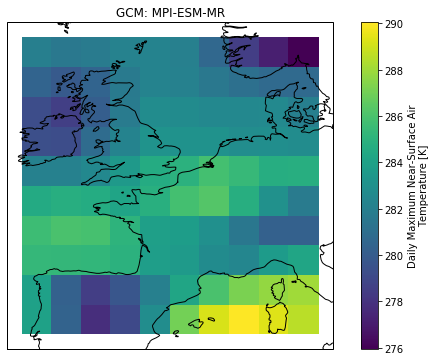

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

time = '2000-01-01'
snapshot = data.sel(time=time).squeeze()
# Plot on coastline
plt.figure(figsize=(10,6))
ax = plt.subplot(projection=ccrs.PlateCarree())
snapshot.plot.pcolormesh('lon', 'lat', ax=ax)
ax.coastlines(resolution='50m')
plt.title('GCM: MPI-ESM-MR')
plt.show()

In [33]:
# Clean this data
# We create a new empty xarray data array and populate this with processed data (standardised 365 day calendar)

lon_values = data['lon'].values
lat_values = data['lat'].values
time_values = pd.date_range('1979-01-01', '2050-12-31')
time_values = dataprocessing.remove_leapyears(pd.DataFrame(index=time_values)).index

data_new = xr.DataArray(np.empty((len(time_values), len(lon_values), len(lat_values))),
                        coords=[('time', time_values),
                                ('lat', lat_values),
                                ('lon', lon_values)])

In [38]:
for i, lat in enumerate(lat_values):
    for j, lon in enumerate(lon_values):
        print("Processing [{}, {}] \n-----------------".format(i, j))
        grid = data.loc[:, lat, lon]
        grid_new = dataprocessing.simple_preprocess_1d(grid, verbose=False)
        data_new.loc[:, lat, lon] = grid_new.values.squeeze()

Processing [0, 0] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [0, 1] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [0, 2] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done

Done simple preprocessing, ouput 1D dataframe. 

Processing [2, 7] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [2, 8] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [2, 9] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rollin

Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [4, 9] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [5, 0] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [5, 1] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset time

Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [7, 2] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [7, 3] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [7, 4] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset time

Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [9, 5] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Processing [9, 6] 
-----------------
Standard initial preprocessing: 

Standardising coordinate names, ordering and rounding to 2 dp...
Converting datetime to y-m-d (reset timestamp)...
(Not rolling longitude)

Standard initial preprocessing done. 

Already in datetime64 format.
Converting to dataframe...
Removing 29-Feb's...
Done simple preprocessing, ouput 1D dataframe. 

Proce

In [39]:
data_new

<xarray.DataArray (time: 26280, lat: 10, lon: 10)>
array([[[287.154722, 283.960541, ..., 289.815904, 288.829895],
        [286.782785, 284.330507, ..., 287.295201, 287.298486],
        ...,
        [282.543825, 280.440419, ..., 277.7289  , 277.396753],
        [282.069614, 281.058076, ..., 273.388116, 273.041773]],

       [[287.367921, 285.06294 , ..., 290.422895, 288.768695],
        [286.833579, 284.82419 , ..., 287.587623, 287.520525],
        ...,
        [280.628526, 278.76274 , ..., 275.644622, 275.817538],
        [278.977342, 277.663158, ..., 265.963957, 265.078213]],

       ...,

       [[289.592526, 288.779719, ..., 289.525202, 288.01896 ],
        [287.601079, 287.310235, ..., 288.331502, 288.467325],
        ...,
        [283.547954, 283.30659 , ..., 282.151009, 281.60431 ],
        [283.410147, 283.542241, ..., 278.180076, 278.623658]],

       [[288.425411, 287.6372  , ..., 289.66568 , 288.685544],
        [285.560389, 284.64695 , ..., 287.798468, 287.482834],
        .

In [ ]:
# Save cleaned window data
data_new.to_netcdf('../data/riskindex/window_MPI-ESM-MR_processed.nc')